### Important links

https://towardsdatascience.com/deep-learning-for-nlp-with-pytorch-and-torchtext-4f92d69052f

https://blog.slavv.com/37-reasons-why-your-neural-network-is-not-working-4020854bd607

In [ ]:
!pip install keras-ocr

     |████████████████████████████████| 41 kB 272 kB/s 
     |████████████████████████████████| 9.5 MB 42.5 MB/s 
     |████████████████████████████████| 603 kB 52.2 MB/s 
     |████████████████████████████████| 890 kB 44.1 MB/s 
     |████████████████████████████████| 50 kB 5.2 MB/s 


In [ ]:
import matplotlib.pyplot as plt
import keras_ocr
import cv2
import math
import os
import numpy as np
from PIL import Image

In [ ]:
class PreprocessImage:

  def __midpoint(self, x1, y1, x2, y2):
    x_mid = int((x1 + x2)/2)
    y_mid = int((y1 + y2)/2)
    return (x_mid, y_mid)

  def inpaint_text(self, img_path, pipeline):
      # read image
      img = keras_ocr.tools.read(img_path)
      # generate (word, box) tuples 
      prediction_groups = pipeline.recognize([img])
      mask = np.zeros(img.shape[:2], dtype="uint8")
      for box in prediction_groups[0]:
          x0, y0 = box[1][0]
          x1, y1 = box[1][1] 
          x2, y2 = box[1][2]
          x3, y3 = box[1][3] 
          
          x_mid0, y_mid0 = self.__midpoint(x1, y1, x2, y2)
          x_mid1, y_mi1 = self.__midpoint(x0, y0, x3, y3)
          
          thickness = int(math.sqrt( (x2 - x1)**2 + (y2 - y1)**2 ))
          
          cv2.line(mask, (x_mid0, y_mid0), (x_mid1, y_mi1), 255,    
          thickness)
          img = cv2.inpaint(img, mask, 7, cv2.INPAINT_NS)
                  
      return (img)

    #enhance the image using filters

In [ ]:
# p = "/content/drive/MyDrive/Image Processing project/Meme Classification/Dataset/Processed Images"
p = "/content/drive/MyDrive/Image Processing project/Meme Classification/Dataset/Labelled Images"
i = os.listdir(p)
print(len(i))

750


In [ ]:
path = "/content/drive/MyDrive/Image Processing project/Meme Classification/Dataset/Labelled Images"
save_path = "/content/drive/MyDrive/Image Processing project/Meme Classification/Dataset/Processed Images"
pipeline = keras_ocr.pipeline.Pipeline()
image_preprocessor = PreprocessImage()

images = os.listdir(path)
images = images[749:]
for image in images:
  image_path = os.path.join(path, image)
  processed = image_preprocessor.inpaint_text(image_path, pipeline)
  processed = Image.fromarray(processed)
  processed.save(os.path.join(save_path, image))

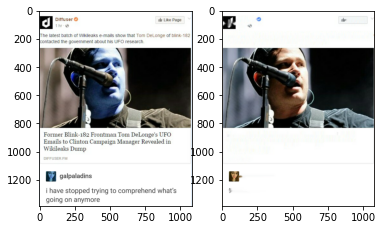

In [ ]:
import matplotlib.pyplot as plt

f, axarr = plt.subplots(1,2)
actual_image = cv2.imread(path)

axarr[0].imshow(actual_image)
axarr[1].imshow(image)

Excellent!!

In [ ]:
path = "/content/drive/MyDrive/Image Processing project/0N5ZKcH.png"
# pipeline = keras_ocr.pipeline.Pipeline()
image = inpaint_text(path, pipeline)

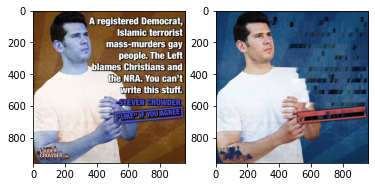

In [ ]:
f, ax = plt.subplots(1,2)
actual_image = cv2.imread(path)

ax[0].imshow(actual_image)
ax[1].imshow(image)

Not Bad. Would work!!

## NLP Preprocessing

In [ ]:
!pip install timm
!pip install -qq albumentations==1.0.3
!pip install torchmetrics
!pip install transformers

     |████████████████████████████████| 376 kB 5.2 MB/s 
     |████████████████████████████████| 98 kB 2.9 MB/s 
     |████████████████████████████████| 47.7 MB 1.2 MB/s 
     |████████████████████████████████| 332 kB 5.2 MB/s 
     |████████████████████████████████| 3.4 MB 4.6 MB/s 
     |████████████████████████████████| 61 kB 475 kB/s 
     |████████████████████████████████| 895 kB 71.7 MB/s 
     |████████████████████████████████| 3.3 MB 63.3 MB/s 
     |████████████████████████████████| 596 kB 59.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#import the libraries.
import matplotlib.pyplot as plt
import cv2
import math
import os
import numpy as np
from PIL import Image
import re 
import string
import torchtext
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
nltk.download('wordnet')
nltk.download('punkt')
from nltk.stem import WordNetLemmatizer

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import timm

import albumentations
from albumentations.pytorch.transforms import ToTensorV2

from torchmetrics import AveragePrecision, Recall, F1
from sklearn.metrics import precision_recall_fscore_support

from tqdm.auto import tqdm
import functools

from transformers import (AutoModel, AutoTokenizer, 
                          AutoModelForSequenceClassification)
 
# Create WordNetLemmatizer object
wnl = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
#lower case, remove special characters, lemmatization, seperate compound words.

class PreprocessText:
  #convert the chars to lower case in the sentence.
  def to_lower(self, sentence):
    return sentence[0].lower().strip()

  #remove punctuations from the sentence.
  def remove_punct(self, sentence):
    return sentence[0].translate(str.maketrans('', '', string.punctuation))

  #expand the contractions in the english words. don't -> do not.
  def decontracted(self, sentence): 
    # specific 
    sentence = re.sub(r"won\'t", "will not", sentence[0]) 
    sentence = re.sub(r"can\'t", "can not", sentence) 
    # general 
    sentence = re.sub(r"n\'t", " not", sentence) 
    sentence = re.sub(r"\'re", " are", sentence) 
    sentence = re.sub(r"\'s", " is", sentence) 
    sentence = re.sub(r"\'d", " would", sentence) 
    sentence = re.sub(r"\'ll", " will", sentence) 
    sentence = re.sub(r"\'t", " not", sentence) 
    sentence = re.sub(r"\'ve", " have", sentence) 
    sentence = re.sub(r"\'m", " am", sentence) 
    return sentence

  def lemmatization(self, sentence, wnl):
    words = sentence[0].split(' ')
    lem_words = []
    for word in words:
      lem_words.append(wnl.lemmatize(word))
    return ' '.join(lem_words)

In [ ]:
tokenizer = torchtext.data.utils.get_tokenizer('basic_english')

train_data = pd.read_csv('/content/drive/MyDrive/Image Processing project/Meme Classification/Dataset/Split Dataset/Training_meme_dataset.csv') #read the train data.
val_data = pd.read_csv('/content/drive/MyDrive/Image Processing project/Meme Classification/Dataset/Split Dataset/Validation_meme_dataset.csv') #read the val data.
test_data = pd.read_csv('/content/drive/MyDrive/Image Processing project/Meme Classification/Dataset/Split Dataset/Testing_meme_dataset.csv') #read the test data.

def text_preprocess_pipeline(file, pp_obj, wnl):
  file['sentence'] = file[['sentence']].apply(pp_obj.to_lower, axis=1)
  file['sentence'] = file[['sentence']].apply(pp_obj.decontracted, axis=1)
  file['sentence'] = file[['sentence']].apply(pp_obj.remove_punct, axis=1)
  file['sentence'] = file[['sentence']].apply(pp_obj.lemmatization, args=(wnl,), axis=1)
  return file

# preprocess all the three csv files using the preprocess object.
text_preprocessor = PreprocessText()
pp_train = text_preprocess_pipeline(train_data.copy(), text_preprocessor, wnl)
pp_val = text_preprocess_pipeline(val_data.copy(), text_preprocessor, wnl)
pp_test = text_preprocess_pipeline(test_data.copy(), text_preprocessor, wnl)

#tokenize all the files.
def tokenize_texts(csv_file):
  sentences = list(csv_file['sentence'])
  tokens = []
  for sentence in sentences:
    tokens.append(word_tokenize(sentence))
  return tokens

train_tokens = tokenize_texts(pp_train)
val_tokens = tokenize_texts(pp_val)
test_tokens = tokenize_texts(pp_test)

# create a vocabulary.
min_freq = 1
special_tokens = ['<unk>', '<pad>']
vocab = torchtext.vocab.build_vocab_from_iterator(train_tokens, min_freq=min_freq, specials=special_tokens)
unk_index = vocab['<unk>']
pad_index = vocab['<pad>']
vocab.set_default_index(unk_index)

#convert text to sequences.
def to_sequence(tokens, vocab):
  return [vocab[token] for token in tokens]

train_sequences = [to_sequence(word_list, vocab) for word_list in train_tokens]
val_sequences = [to_sequence(word_list, vocab) for word_list in val_tokens]
test_sequences = [to_sequence(word_list, vocab) for word_list in test_tokens]

vocab_length = len(vocab)

In [ ]:
list(pp_train['sentence'])[0], list(train_data['sentence'])[0]

('official bernie sander drinking game  every time the bernster mention a free government program  chug somebody else  is beer ',
 "OFFICIAL BERNIE SANDERS DRINKING GAME ! Every time The Bernster mentions a free government program , chug somebody else 's beer ! ")

In [ ]:
list(pp_train[pp_train['image_name'] == 'yZLLqn4.png']['sentence'])

['hillary clinton  is policy for black american home summedupin one picture']

## Utils

In [ ]:
#Data augmentation.
def train_transform_object(DIM = 384):
    return albumentations.Compose(
        [
            albumentations.Resize(DIM,DIM),
            albumentations.RandomBrightnessContrast(
                brightness_limit=(-0.1, 0.1),
                contrast_limit=(-0.1, 0.1), p=0.5
            ),
            albumentations.Flip(p=0.5),
            albumentations.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(p=1.0),
        ]
    )

def valid_transform_object(DIM = 384):
    return albumentations.Compose(
        [
            albumentations.Resize(DIM,DIM),
            albumentations.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(p=1.0)
        ]
    )

#Device selection.
def select_device():
  if torch.cuda.is_available():
      return torch.device('cuda')
  device = torch.device('cpu')

## Dataset

In [ ]:
class MemeTrainSet(Dataset):

  def __init__(self, image_paths, image_captions, labels, transform=None):
    self.image_paths = image_paths
    self.image_captions = image_captions
    self.labels = labels
    self.transform = transform

    #tokenizer object.

  def __len__(self):
    return len(self.image_captions)

  def __getitem__(self, index):
    img = cv2.imread(self.image_paths[index], 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #preprocess the image. TO BE DONE.
    if self.transform is not None:
      img = self.transform(image=img)['image']
    # img = img.float()

    #text.
    caption = self.image_captions[index]
    caption = np.asarray(caption)

    label = torch.tensor(1 if self.labels[index] == 'offensive' else 0).int()

    return (img, caption, label)

In [ ]:
class MemeTrainSetBert(Dataset):

  def __init__(self, image_paths, image_captions, labels, transform=None):
    self.image_paths = image_paths
    self.image_captions = image_captions
    self.labels = labels
    self.transform = transform

  def __len__(self):
    return len(self.image_captions)

  def __getitem__(self, index):
    img = cv2.imread(self.image_paths[index], 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if self.transform is not None:
      img = self.transform(image=img)['image']

    caption = self.image_captions[index]

    label = torch.tensor(1 if self.labels[index] == 'offensive' else 0).int()

    return (img, caption, label)

## Model

In [ ]:
class MemeModelConcat(nn.Module):

  def __init__(self, image_model, out_features, inp_channels, vocab_size, embedding_dim, pad_index, drop_prob=0.2, pretrained=True):
    super().__init__()
    #image pretrained model.
    self.image_model = timm.create_model(image_model, pretrained=pretrained, in_chans=inp_channels)
    n_features = self.image_model.head.in_features #replace fc with head.
    self.image_model.head = nn.Linear(n_features, 128)

    #language model layers.
    self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_index)
    self.lstm_1 = nn.LSTM(embedding_dim, 128, 2, dropout=drop_prob, batch_first=True, bidirectional=True)
    self.lstm_2 = nn.LSTM(256, 64, 2, dropout=drop_prob, batch_first=True, bidirectional=True)

    #feed forward layers.
    self.fc = nn.Sequential(
      nn.Linear(256, 64),
      nn.ReLU(),
      nn.Dropout(drop_prob),
      nn.Linear(64, out_features)
    )
    self.dropout = nn.Dropout(drop_prob)

  def forward(self, image, text):
    img_feats = self.image_model(image)
    img_feats = self.dropout(img_feats)
    text_embed = self.embedding(text)
    lstm_out, _ = self.lstm_1(text_embed)
    lstm_out, _ = self.lstm_2(lstm_out)
    # text_feats = lstm_out[:, -1, :]
    text_feats = torch.sum(lstm_out, axis=1)/lstm_out.shape[1] #mean pooling.
    feats = torch.cat([img_feats, text_feats], dim=1)

    output = self.fc(feats)

    return output

In [ ]:
class MemeModelConcatBert(nn.Module):

  def __init__(self, image_model, out_features, inp_channels, embedding_dim, drop_prob=0.2, pretrained=True):
    super().__init__()
    #image pretrained model.
    self.image_model = timm.create_model(image_model, pretrained=pretrained, in_chans=inp_channels)
    n_features = self.image_model.head.in_features
    self.image_model.head = nn.Linear(n_features, 128)

    #language model layers.
    self.lstm_1 = nn.LSTM(embedding_dim, 128, 2, dropout=drop_prob, batch_first=True, bidirectional=True)
    self.lstm_2 = nn.LSTM(256, 64, 2, dropout=drop_prob, batch_first=True, bidirectional=True)

    #feed forward layers.
    self.fc = nn.Sequential(
      nn.Linear(256, 64),
      nn.ReLU(),
      nn.Dropout(drop_prob),
      nn.Linear(64, out_features)
    )
    self.dropout = nn.Dropout(drop_prob)

  def forward(self, image, text):
    img_feats = self.image_model(image)
    img_feats = self.dropout(img_feats)
    lstm_out, _ = self.lstm_1(text)
    lstm_out, _ = self.lstm_2(lstm_out)
    text_feats = torch.sum(lstm_out, axis=1)/lstm_out.shape[1] 
    feats = torch.cat([img_feats, text_feats], dim=1)

    output = self.fc(feats)

    return output

class EmbeddingModel(nn.Module):
  def __init__(self, embedding_model, embedding_dim):
    super().__init__()
    self.bert = AutoModel.from_pretrained(embedding_model)

  def forward(self,**xb):
    return self.bert(**xb)[0]

In [ ]:
class AttentionHead(nn.Module):
    def __init__(self, in_features, hidden_dim, num_targets):
        super().__init__()
        self.in_features = in_features
        self.middle_features = hidden_dim

        self.W = nn.Linear(in_features, hidden_dim)
        self.V = nn.Linear(hidden_dim, 1)
        self.out_features = hidden_dim

    def forward(self, features):
        att = torch.tanh(self.W(features))

        score = self.V(att)

        attention_weights = torch.softmax(score, dim=1)

        context_vector = attention_weights * features
        context_vector = torch.sum(context_vector, dim=1)

        return context_vector

class MemeModelConcatBertAttention(nn.Module):

  def __init__(self, image_model, out_features, inp_channels, embedding_dim, drop_prob=0.2, pretrained=True):
    super().__init__()
    #image pretrained model.
    self.image_model = timm.create_model(image_model, pretrained=pretrained, in_chans=inp_channels)
    n_features = self.image_model.head.in_features
    self.image_model.head = nn.Linear(n_features, 128)

    #language model layers.
    self.lstm_1 = nn.LSTM(embedding_dim, 128, 2, dropout=drop_prob, batch_first=True, bidirectional=True)
    self.lstm_2 = nn.LSTM(256, 64, 2, dropout=drop_prob, batch_first=True, bidirectional=True)
    self.head = AttentionHead(128, 128, out_features)

    #feed forward layers.
    self.fc = nn.Sequential(
      nn.Linear(256, 64),
      nn.ReLU(),
      nn.Dropout(drop_prob),
      nn.Linear(64, out_features)
    )
    self.dropout = nn.Dropout(drop_prob)

  def forward(self, image, text):
    img_feats = self.image_model(image)
    img_feats = self.dropout(img_feats)
    lstm_out, _ = self.lstm_1(text)
    lstm_out, _ = self.lstm_2(lstm_out)
    text_feats = self.head(lstm_out)
    feats = torch.cat([img_feats, text_feats], dim=1)
    output = self.fc(feats)
    return output

class EmbeddingModel(nn.Module):
  def __init__(self, embedding_model, embedding_dim):
    super().__init__()
    self.bert = AutoModel.from_pretrained(embedding_model)

  def forward(self,**xb):
    return self.bert(**xb)[0]

In [ ]:
class MemeModelImage(nn.Module):

  def __init__(self, image_model, out_features, inp_channels, vocab_size, embedding_dim, pad_index, drop_prob=0.2, pretrained=True):
    super().__init__()
    #image pretrained model.
    self.image_model = timm.create_model(image_model, pretrained=pretrained, in_chans=inp_channels)
    n_features = self.image_model.fc.in_features #replace fc with head.
    self.image_model.fc = nn.Linear(n_features, 128)

    #feed forward layers.
    self.fc = nn.Sequential(
      nn.Linear(128, 64),
      nn.ReLU(),
      nn.Dropout(drop_prob),
      nn.Linear(64, out_features)
    )
    self.dropout = nn.Dropout(drop_prob)

  def forward(self, image, text):
    img_feats = self.image_model(image)
    img_feats = self.dropout(img_feats)
    output = self.fc(img_feats)
    return output

In [ ]:
class MemeModelText(nn.Module):

  def __init__(self, image_model, out_features, inp_channels, vocab_size, embedding_dim, pad_index, drop_prob=0.2, pretrained=True):
    super().__init__()

    #language model layers.
    self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_index)
    self.lstm_1 = nn.LSTM(embedding_dim, 128, 2, dropout=drop_prob, batch_first=True, bidirectional=True)
    self.lstm_2 = nn.LSTM(256, 64, 2, dropout=drop_prob, batch_first=True, bidirectional=True)

    #feed forward layers.
    self.fc = nn.Sequential(
      nn.Linear(128, 64),
      nn.ReLU(),
      nn.Dropout(drop_prob),
      nn.Linear(64, out_features)
    )
    self.dropout = nn.Dropout(drop_prob)

  def forward(self, image, text):
    text_embed = self.embedding(text)
    lstm_out, _ = self.lstm_1(text_embed)
    lstm_out, _ = self.lstm_2(lstm_out)
    text_feats = torch.sum(lstm_out, axis=1)/lstm_out.shape[1] #mean pooling.
    output = self.fc(text_feats)
    return output

## Metrics

In [ ]:
#numpy format with 0's and 1's.
def calc_precision(preds, targets):
  average_precision = AveragePrecision(average='micro')
  return average_precision(preds, targets)

def calc_recall(preds, targets):
  recall = Recall(average='micro')
  return recall(preds, targets)

def calc_f1score(preds, targets):
  f1 = F1(average='micro')
  return f1(preds, targets)

def calc_precision_recall_f1score(preds, targets):
  targets = targets.detach().cpu().numpy()
  preds = preds.detach().cpu().numpy()
  prf = precision_recall_fscore_support(targets, preds, average='weighted')
  return round(prf[0], 3), round(prf[1], 3), round(prf[2], 3)

## Train and Test functions

In [ ]:
def bin_tonp_tocpu(outputs, targets):
  outputs = torch.sigmoid(outputs)
  targets = targets.detach().cpu().numpy()
  outputs = outputs.detach().cpu().numpy()
  for index in range(len(outputs)):
    if outputs[index] >= 0.5:
      outputs[index] = 1
    else:
      outputs[index] = 0
  return torch.tensor(outputs).int(), torch.tensor(targets).int()

def train_fn(train_loader, model, loss_fn, optimizer, epoch, device, scheduler=None):
    model.train()
    stream = tqdm(train_loader)
    loss_val = 0
    final_loss = 0
    # out_st, tar_st = None, None

    for i, (image, text, target) in enumerate(stream, start=1):
        image = image.to(device, non_blocking=True)
        text = text.to(device, non_blocking=True)
        target = target.to(device, non_blocking=True).float().view(-1, 1)

        output = model(image, text)

        loss = loss_fn(output, target)
        loss_val += loss.item()
        final_loss = loss_val/i
        # outputs, targets = bin_tonp_tocpu(output, target)
        # if out_st is None:
        #   out_st, tar_st = outputs.squeeze(1), targets.squeeze(1)
        # else:
        #   out_st, tar_st = torch.cat([out_st, outputs.squeeze(1)]), torch.cat([tar_st, targets.squeeze(1)])
        # wt_precision, wt_recall, wt_f1 = calc_precision_recall_f1score(out_st, tar_st)
        # stream.set_description(f"Epoch {epoch:02}. Train. Loss {final_loss}. Precision {wt_precision}. Recall {wt_recall}. F1Score {wt_f1}")
        stream.set_description(f"Epoch {epoch:02}. Train. Loss {final_loss}")

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    return final_loss

def validation_fn(validation_loader, model, loss_fn, epoch, device):
    model.eval()
    stream = tqdm(validation_loader)
    final_targets = []
    final_outputs = []
    loss_val = 0
    final_loss = 0
    out_st, tar_st = None, None
    
    with torch.no_grad():
        for i, (image, text, target) in enumerate(stream, start=1):
            image = image.to(device, non_blocking=True)
            text = text.to(device, non_blocking=True)
            target = target.to(device, non_blocking=True).float().view(-1, 1)
    
            output = model(image, text)

            loss = loss_fn(output, target)
            loss_val += loss.item()
            final_loss = loss_val/i
            outputs, targets = bin_tonp_tocpu(output, target)
            if out_st is None:
              out_st, tar_st = outputs.squeeze(1), targets.squeeze(1)
            else:
              out_st, tar_st = torch.cat([out_st, outputs.squeeze(1)]), torch.cat([tar_st, targets.squeeze(1)])
            wt_precision, wt_recall, wt_f1 = calc_precision_recall_f1score(out_st, tar_st)
            stream.set_description(f"Epoch: {epoch:02}. Valid. Loss {final_loss}. Precision {wt_precision}. Recall {wt_recall}. F1Score {wt_f1}")
            
            target = (target.detach().cpu().numpy()).tolist()
            output = (output.detach().cpu().numpy()).tolist()
            
            final_targets.extend(target)
            final_outputs.extend(output)
    # return out_st, tar_st
    return final_loss, torch.tensor(final_targets), torch.tensor(final_outputs)

## Training loop (Learnt Embeddings)

In [ ]:
EPOCHS = 10
device = select_device()

def get_dataset(df, sequences, images, state='training'):
    ids = list(df['image_name'])
    image_paths = [os.path.join(images, idx) for idx in ids]
    target = df['label'].values

    if state == 'training':
        transform = train_transform_object(224)
    elif state == 'validation' or state == 'testing':
        transform = valid_transform_object(224)
    else:
        transform = None

    return MemeTrainSet(image_paths, sequences, target, transform)

train = pd.read_csv("/content/drive/MyDrive/Image Processing project/Meme Classification/Dataset/Split Dataset/Training_meme_dataset.csv")
val = pd.read_csv("/content/drive/MyDrive/Image Processing project/Meme Classification/Dataset/Split Dataset/Validation_meme_dataset.csv")

images = "/content/drive/MyDrive/Image Processing project/Meme Classification/Dataset/Processed Images" #path to the images folder.

train_dataset = get_dataset(train, train_sequences, images)
val_dataset = get_dataset(val, val_sequences, images, state='validation')

def collate_fn(batch, pad_index):
  images = torch.stack([ex[0] for ex in batch])
  labels = torch.stack([ex[2] for ex in batch])
  captions = [torch.tensor(ex[1]) for ex in batch]
  captions = nn.utils.rnn.pad_sequence(captions, padding_value=pad_index, batch_first=True)
  return images, captions, labels

collate_fn = functools.partial(collate_fn, pad_index=pad_index)
collate_fn = functools.partial(collate_fn, embed_model=embed_model)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

model_params = {
    'image_model' : 'swin_small_patch4_window7_224',
    'out_features' : 1,
    'inp_channels' : 3,
    'vocab_size' : vocab_length,
    'embedding_dim' : 300,
    'pad_index' : pad_index,
    'drop_prob' : 0.3,
    'pretrained' : True
}
model = MemeModelConcatBert(**model_params)
model = model.to(device)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-6, amsgrad=False)

train_losses, val_losses = [], []
model_folder = os.path.join("/content/drive/MyDrive/Image Processing project/Meme Classification", model_params['image_model'] + '_BiLSTM')
for epoch in range(EPOCHS):
    train_loss = train_fn(train_loader, model, loss_fn, optimizer, epoch, device)
    val_loss, valid_targets, predictions = validation_fn(val_loader, model, loss_fn, epoch, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    outputs, targets = bin_tonp_tocpu(predictions, valid_targets)
    wt_precision, wt_recall, wt_f1 = calc_precision_recall_f1score(outputs, targets)

    if not os.path.exists(model_folder):
      os.mkdir(model_folder)
    
    model_name = f"{model_params['image_model'] + '_BiLSTM'}_epoch_{epoch}.pth"
    torch.save(model.state_dict(), os.path.join(model_folder, model_name))
    print(f'The saved model is: {model_name}')

## Training Loop (DistilBert Embeddings)

In [ ]:
EPOCHS = 10
embedding_dim = 768
embedding_model = 'distilbert-base-uncased'
device = select_device()

def get_dataset(df, tokens, images, state='training'):
    ids = list(df['image_name'])
    image_paths = [os.path.join(images, idx) for idx in ids]
    target = df['label'].values

    if state == 'training':
        transform = train_transform_object(224)
    elif state == 'validation' or state == 'testing':
        transform = valid_transform_object(224)
    else:
        transform = None

    return MemeTrainSetBert(image_paths, tokens, target, transform)

train = pd.read_csv("/content/drive/MyDrive/Image Processing project/Meme Classification/Dataset/Split Dataset/Training_meme_dataset.csv")
val = pd.read_csv("/content/drive/MyDrive/Image Processing project/Meme Classification/Dataset/Split Dataset/Validation_meme_dataset.csv")

images = "/content/drive/MyDrive/Image Processing project/Meme Classification/Dataset/Processed Images" #path to the images folder.

train_dataset = get_dataset(train, train_tokens, images)
val_dataset = get_dataset(val, val_tokens, images, state='validation')

def collate_fn(batch, tokenizer, embed_model):
  print(batch)
  images = torch.stack([ex[0] for ex in batch])
  labels = torch.stack([ex[2] for ex in batch])

  max_len, captions = -1, []
  for ex in batch:
    captions.append(ex[1])
    max_len = max(max_len, len(ex[1]))

  sequences = tokenizer(captions, return_tensors='pt', 
                                max_length=max_len, is_split_into_words=True,
                                padding='max_length',truncation=True)
  captions = embed_model(**sequences)
  return images, captions, labels

embed_model = EmbeddingModel(embedding_model, embedding_dim)
embed_model.eval()
tokenizer = AutoTokenizer.from_pretrained(embedding_model)
collate_fn = functools.partial(collate_fn, tokenizer=tokenizer, embed_model=embed_model)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)

model_params = {
    'image_model' : 'swin_small_patch4_window7_224',
    'out_features' : 1,
    'inp_channels' : 3,
    'embedding_dim' : embedding_dim,
    'drop_prob' : 0.2,
    'pretrained' : True
}
model = MemeModelConcatBertAttention(**model_params)
model = model.to(device)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-6, amsgrad=False)

train_losses, val_losses = [], []
model_folder = os.path.join("/content/drive/MyDrive/Image Processing project/Meme Classification", model_params['image_model'] + '_BiLSTM_DistilBert_Attention')
for epoch in range(EPOCHS):
    train_loss = train_fn(train_loader, model, loss_fn, optimizer, epoch, device)
    val_loss, valid_targets, predictions = validation_fn(val_loader, model, loss_fn, epoch, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    outputs, targets = bin_tonp_tocpu(predictions, valid_targets)
    wt_precision, wt_recall, wt_f1 = calc_precision_recall_f1score(outputs, targets)

    if not os.path.exists(model_folder):
      os.mkdir(model_folder)
    
    model_name = f"{model_params['image_model'] + '_BiLSTM_DistilBert'}_epoch_{epoch}.pth"
    torch.save(model.state_dict(), os.path.join(model_folder, model_name))
    print(f'The saved model is: {model_name}')

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/28 [00:00<?, ?it/s]

[(tensor([[[ 1.8208,  1.8208,  1.8208,  ...,  1.8208,  1.8208,  1.8208],
         [ 1.8208,  1.8208,  1.8208,  ...,  1.8208,  1.8208,  1.8208],
         [ 1.8208,  1.8208,  1.8208,  ...,  1.8208,  1.8208,  1.8208],
         ...,
         [-0.7993, -0.5596, -0.5253,  ..., -1.7069, -1.5699, -1.6213],
         [ 1.0502,  1.1187,  1.0331,  ..., -1.7069, -1.5528, -1.6042],
         [ 1.1358,  1.0844,  0.8618,  ..., -1.7069, -1.7754, -1.9980]],

        [[ 1.9909,  1.9909,  1.9909,  ...,  1.9909,  1.9909,  1.9909],
         [ 1.9909,  1.9909,  1.9909,  ...,  1.9909,  1.9909,  1.9909],
         [ 1.9909,  1.9909,  1.9909,  ...,  1.9909,  1.9909,  1.9909],
         ...,
         [-0.7577, -0.5301, -0.4776,  ..., -1.0028, -0.8452, -0.9153],
         [ 1.0630,  1.1681,  1.0455,  ..., -1.0028, -0.8277, -0.8978],
         [ 1.0980,  1.0630,  0.8004,  ..., -1.0028, -1.0553, -1.2829]],

        [[ 2.2043,  2.2043,  2.2043,  ...,  2.2043,  2.2043,  2.2043],
         [ 2.2043,  2.2043,  2.2043,  ..., 

KeyboardInterrupt: ignored

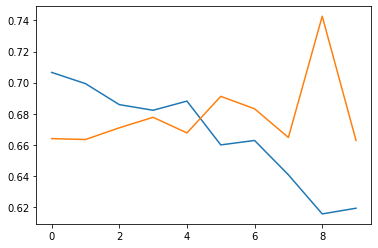

In [ ]:
plt.plot(train_losses)
plt.plot(val_losses)
plt.show()

In [ ]:
train_losses, val_losses

([0.7065816351345607,
  0.6993712569986071,
  0.6858597312654767,
  0.6822336997304644,
  0.6881349001611982,
  0.6599515889372144,
  0.6628114836556571,
  0.6407127295221601,
  0.6155588712011065,
  0.6192224557910647],
 [0.6640015840530396,
  0.6634217143058777,
  0.6709506034851074,
  0.6777173280715942,
  0.6676606655120849,
  0.6911746382713317,
  0.6831886768341064,
  0.6647293925285339,
  0.7427173018455505,
  0.6628115177154541])

# Testing

In [ ]:
def test_fn(test_loader, model, device):
    model.eval()
    stream = tqdm(test_loader)
    final_targets = []
    final_outputs = []
    
    with torch.no_grad():
        for i, (image, text, target) in enumerate(stream, start=1):
            image = image.to(device, non_blocking=True)
            text = text.to(device, non_blocking=True)
            target = target.to(device, non_blocking=True).float().view(-1, 1)
    
            output = model(image, text)
            
            target = (target.detach().cpu().numpy()).tolist()
            output = (output.detach().cpu().numpy()).tolist()
            
            final_targets.extend(target)
            final_outputs.extend(output)
        
    return final_targets, final_outputs

## Testing Loop (Learnt Embeddings)

In [ ]:
from tqdm.auto import tqdm
import functools
from sklearn.metrics import confusion_matrix
import seaborn

model_params = {
    'image_model' : 'vit_base_patch16_224',
    'out_features' : 1,
    'inp_channels' : 3,
    'vocab_size' : vocab_length,
    'embedding_dim' : 300,
    'pad_index' : pad_index,
    'drop_prob' : 0.3,
    'pretrained' : False
}

device = select_device()

model_path = "/content/drive/MyDrive/Image Processing project/Meme Classification/vit_base_patch16_224_BiLSTM_DistilBert/vit_base_patch16_224_BiLSTM_DistilBert_epoch_9.pth"
model = MemeModelConcat(**model_params)
model.load_state_dict(torch.load(model_path))
model = model.to(device)

def get_dataset(df, sequences, images, state='training'):
    ids = list(df['image_name'])
    image_paths = [os.path.join(images, idx) for idx in ids]
    target = df['label'].values

    if state == 'training':
        transform = train_transform_object(224)
    elif state == 'validation' or state == 'testing':
        transform = valid_transform_object(224)
    else:
        transform = None

    return MemeTrainSet(image_paths, sequences, target, transform)

test = pd.read_csv("/content/drive/MyDrive/Image Processing project/Meme Classification/Dataset/Split Dataset/Testing_meme_dataset.csv")
images = "/content/drive/MyDrive/Image Processing project/Meme Classification/Dataset/Processed Images" #path to the images folder.
test_dataset = get_dataset(test, test_sequences, images, state='testing')

def collate_fn(batch, pad_index):
  images = torch.stack([ex[0] for ex in batch])
  labels = torch.stack([ex[2] for ex in batch])
  captions = [torch.tensor(ex[1]) for ex in batch]
  captions = nn.utils.rnn.pad_sequence(captions, padding_value=pad_index, batch_first=True)
  return images, captions, labels

collate_fn = functools.partial(collate_fn, pad_index=pad_index)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

loss_fn = nn.BCEWithLogitsLoss()

test_targets, predictions = test_fn(test_loader, model, device)



NameError: ignored

## Testing Loop (DistilBert Embeddings)

In [ ]:
from tqdm.auto import tqdm
import functools
from sklearn.metrics import confusion_matrix
import seaborn

embedding_dim = 768
embedding_model = 'distilbert-base-uncased'

model_params = {
    'image_model' : 'vit_base_patch16_224',
    'out_features' : 1,
    'inp_channels' : 3,
    'embedding_dim' : embedding_dim,
    'drop_prob' : 0.3,
    'pretrained' : False
}

device = select_device()

model_path = "/content/drive/MyDrive/Image Processing project/Meme Classification/vit_base_patch16_224_BiLSTM_DistilBert/vit_base_patch16_224_BiLSTM_DistilBert_epoch_9.pth"
model = MemeModelConcatBert(**model_params)
model.load_state_dict(torch.load(model_path))
model = model.to(device)

def get_dataset(df, tokens, images, state='training'):
    ids = list(df['image_name'])
    image_paths = [os.path.join(images, idx) for idx in ids]
    target = df['label'].values

    if state == 'training':
        transform = train_transform_object(224)
    elif state == 'validation' or state == 'testing':
        transform = valid_transform_object(224)
    else:
        transform = None

    return MemeTrainSetBert(image_paths, tokens, target, transform)

test = pd.read_csv("/content/drive/MyDrive/Image Processing project/Meme Classification/Dataset/Split Dataset/Testing_meme_dataset.csv")
images = "/content/drive/MyDrive/Image Processing project/Meme Classification/Dataset/Processed Images" #path to the images folder.
test_dataset = get_dataset(test, test_tokens, images, state='testing')

def collate_fn(batch, tokenizer, embed_model):
  images = torch.stack([ex[0] for ex in batch])
  labels = torch.stack([ex[2] for ex in batch])

  max_len, captions = -1, []
  for ex in batch:
    captions.append(ex[1])
    max_len = max(max_len, len(ex[1]))

  sequences = tokenizer(captions, return_tensors='pt', 
                                max_length=max_len, is_split_into_words=True,
                                padding='max_length',truncation=True)
  captions = embed_model(**sequences)
  return images, captions, labels

embed_model = EmbeddingModel(embedding_model, embedding_dim)
embed_model.eval()
tokenizer = AutoTokenizer.from_pretrained(embedding_model)
collate_fn = functools.partial(collate_fn, tokenizer=tokenizer, embed_model=embed_model)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

loss_fn = nn.BCEWithLogitsLoss()

test_targets, predictions = test_fn(test_loader, model, device)



Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
def test_fn(test_loader, model, device):
    model.eval()
    stream = tqdm(test_loader)
    final_targets = []
    final_outputs = []
    
    with torch.no_grad():
        for i, (image, text, target) in enumerate(stream, start=1):
            image = image.to(device, non_blocking=True)
            text = text.to(device, non_blocking=True)
            target = target.to(device, non_blocking=True).float().view(-1, 1)
    
            output = model(image, text)
            
            target = (target.detach().cpu().numpy()).tolist()
            output = (output.detach().cpu().numpy()).tolist()
            
            final_targets.extend(target)
            final_outputs.extend(output)
        
    return final_targets, final_outputs

from tqdm.auto import tqdm
import functools
from sklearn.metrics import confusion_matrix
import seaborn

embedding_dim = 768
embedding_model = 'distilbert-base-uncased'

model_params = {
    'image_model' : 'vit_base_patch16_224',
    'out_features' : 1,
    'inp_channels' : 3,
    'embedding_dim' : embedding_dim,
    'drop_prob' : 0.3,
    'pretrained' : False
}

device = select_device()

model_path = "/content/drive/MyDrive/Image Processing project/Meme Classification/vit_base_patch16_224_BiLSTM_DistilBert/vit_base_patch16_224_BiLSTM_DistilBert_epoch_9.pth"
model = MemeModelConcatBert(**model_params)
model.load_state_dict(torch.load(model_path))
model = model.to(device)

def get_dataset(df, tokens, images, state='training'):
    ids = list(df['image_name'])
    image_paths = [os.path.join(images, idx) for idx in ids]
    target = df['label'].values

    if state == 'training':
        transform = train_transform_object(224)
    elif state == 'validation' or state == 'testing':
        transform = valid_transform_object(224)
    else:
        transform = None

    return MemeTrainSetBert(image_paths, tokens, target, transform)

test = pd.read_csv("/content/drive/MyDrive/Image Processing project/Meme Classification/Dataset/Split Dataset/Testing_meme_dataset.csv")
images = "/content/drive/MyDrive/Image Processing project/Meme Classification/Dataset/Processed Images" #path to the images folder.
test_dataset = get_dataset(test, test_tokens, images, state='testing')

def collate_fn(batch, tokenizer, embed_model):
  images = torch.stack([ex[0] for ex in batch])
  labels = torch.stack([ex[2] for ex in batch])

  max_len, captions = -1, []
  for ex in batch:
    captions.append(ex[1])
    max_len = max(max_len, len(ex[1]))

  sequences = tokenizer(captions, return_tensors='pt', 
                                max_length=max_len, is_split_into_words=True,
                                padding='max_length',truncation=True)
  captions = embed_model(**sequences)
  return images, captions, labels

embed_model = EmbeddingModel(embedding_model, embedding_dim)
embed_model.eval()
tokenizer = AutoTokenizer.from_pretrained(embedding_model)
collate_fn = functools.partial(collate_fn, tokenizer=tokenizer, embed_model=embed_model)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

loss_fn = nn.BCEWithLogitsLoss()

test_targets, predictions = test_fn(test_loader, model, device)



## Visualize the test results

Text(0.5, 1.0, 'ViT + Stacked BiLSTM + Mean Pooling + DistilBert')

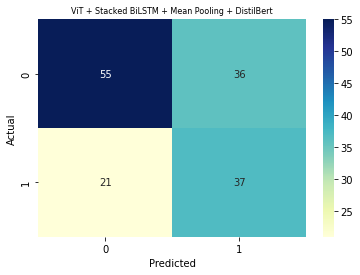

In [ ]:
op = []
for x in predictions:
  z = 1/(1 + np.exp(-x[0]))
  if z >= 0.5: #63, 28, 28, 30
    op.append(1) 
  else:
    op.append(0)
cf_matrix = confusion_matrix(test_targets, op)
seaborn.heatmap(cf_matrix, annot=True, cmap="YlGnBu")
plt.xlabel('Predicted', fontsize = 10) # x-axis label with fontsize 15
plt.ylabel('Actual', fontsize = 10) # y-axis label with fontsize 15
plt.title('ViT + Stacked BiLSTM + Mean Pooling + DistilBert', fontsize = 8) # y-axis label with fontsize 15

In [ ]:
tar = [int(x[0]) for x in test_targets]
print(np.array(tar))
print(np.array(op))

[1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 1 1 0 0 1 0 1 1 0 1 0 0 1 1 0 0 0 0
 0 1 0 0 1 0 0 0 1 1 0 0 1 0 0 1 0 0 0 0 1 0 1 1 1 0 1 1 1 1 1 0 1 0 0 0 0
 0 0 1 0 0 1 1 1 0 1 0 1 1 0 0 1 1 0 1 0 1 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 1 0 1 1 0 1 1 0 1 0 1 1 0 1 1 0 0 0 0 0 0 1 1 1 0 0 0 0 0
 0]
[0 1 1 1 0 0 0 1 1 0 1 1 1 1 0 1 1 0 1 0 1 0 0 0 1 0 1 0 0 0 0 1 1 0 1 1 1
 0 1 1 0 0 0 0 0 1 1 1 0 1 0 0 1 0 0 1 0 0 1 0 1 0 0 1 1 1 1 1 1 1 1 1 0 0
 0 0 0 0 1 1 1 1 0 1 1 0 0 0 1 0 1 0 0 1 1 0 0 0 1 1 0 1 0 1 0 0 1 0 0 1 1
 0 0 0 1 0 0 0 0 1 0 1 0 1 1 1 0 1 1 1 1 0 1 0 0 0 0 0 0 1 0 1 0 0 1 1 1 0
 1]


In [ ]:
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(tar, op, average='weighted')

(0.6392786807507875, 0.6174496644295302, 0.6221709969067449, None)

In [ ]:
count1 = 0
count2 = 0
for i, j in zip(op, tar):
  if i == j and i == 0:
    count1 += 1
  elif i == j and i == 1:
    count2 += 1
print(count1, count2)

71 15


In [ ]:
predictions

[[-0.22418539226055145],
 [0.5237677693367004],
 [1.0522949695587158],
 [-0.4868132472038269],
 [-0.5421532392501831],
 [-0.270601749420166],
 [-0.24406839907169342],
 [0.3536587357521057],
 [0.3217353820800781],
 [-0.2521415948867798],
 [-0.295789897441864],
 [0.03954397141933441],
 [-0.7211561799049377],
 [0.228097066283226],
 [-0.6972655057907104],
 [-0.41534972190856934],
 [-0.29960501194000244],
 [-0.05470629036426544],
 [0.3658202886581421],
 [-0.2635459303855896],
 [-0.4770198464393616],
 [-0.5308622121810913],
 [1.0525102615356445],
 [-0.348891019821167],
 [0.9717379212379456],
 [-0.22531263530254364],
 [-0.7876797318458557],
 [-0.1967763900756836],
 [-0.34975743293762207],
 [-0.5815940499305725],
 [-1.170928955078125],
 [0.08473025262355804],
 [-0.17644667625427246],
 [-0.2749727964401245],
 [-0.6387668251991272],
 [-0.9839218258857727],
 [-0.1429053694009781],
 [-0.7166764736175537],
 [-1.1848304271697998],
 [-0.774039089679718],
 [-1.0670546293258667],
 [0.08778861165046692]

# Soft Voting

In [ ]:
from tqdm.auto import tqdm
import functools
from sklearn.metrics import confusion_matrix
import seaborn

def test_fn(test_loader, model, device):
    model.eval()
    stream = tqdm(test_loader)
    final_targets = []
    final_outputs = []
    
    with torch.no_grad():
        for i, (image, text, target) in enumerate(stream, start=1):
            image = image.to(device, non_blocking=True)
            text = text.to(device, non_blocking=True)
            target = target.to(device, non_blocking=True).float().view(-1, 1)
    
            output = model(image, text)
            
            target = (target.detach().cpu().numpy()).tolist()
            output = (output.detach().cpu().numpy()).tolist()
            
            final_targets.extend(target)
            final_outputs.extend(output)
        
    return final_targets, final_outputs

embedding_dim = 768
embedding_model = 'distilbert-base-uncased'

#model parameters.
model_params1 = {
    'image_model' : 'swin_small_patch4_window7_224',
    'out_features' : 1,
    'inp_channels' : 3,
    'vocab_size' : vocab_length,
    'embedding_dim' : 300,
    'pad_index' : pad_index,
    'drop_prob' : 0.3,
    'pretrained' : False
}
model_params2 = {
    'image_model' : 'vit_base_patch16_224',
    'out_features' : 1,
    'inp_channels' : 3,
    'vocab_size' : vocab_length,
    'embedding_dim' : 300,
    'pad_index' : pad_index,
    'drop_prob' : 0.3,
    'pretrained' : False
}
model_params3 = {
    'image_model' : 'swin_small_patch4_window7_224',
    'out_features' : 1,
    'inp_channels' : 3,
    'embedding_dim' : embedding_dim,
    'drop_prob' : 0.3,
    'pretrained' : False
}
model_params4 = {
    'image_model' : 'vit_base_patch16_224',
    'out_features' : 1,
    'inp_channels' : 3,
    'embedding_dim' : embedding_dim,
    'drop_prob' : 0.3,
    'pretrained' : False
}

device = select_device()

#model paths.
model_paths = [
               "/content/drive/MyDrive/Image Processing project/Meme Classification/swin_small_patch4_window7_224_Bilstm/swin_small_patch4_window7_224_BiLSTM_epoch_5.pth",
               "/content/drive/MyDrive/Image Processing project/Meme Classification/vit_base_patch16_224_BiLSTM/vit_base_patch16_224_BiLSTM_epoch_9.pth",
               "/content/drive/MyDrive/Image Processing project/Meme Classification/swin_small_patch4_window7_224_BiLSTM_DistilBert/swin_small_patch4_window7_224_BiLSTM_DistilBert_epoch_7.pth",
               "/content/drive/MyDrive/Image Processing project/Meme Classification/vit_base_patch16_224_BiLSTM_DistilBert/vit_base_patch16_224_BiLSTM_DistilBert_epoch_9.pth"
]

#models.
models = [
        MemeModelConcat(**model_params1),
        MemeModelConcat(**model_params2),
        MemeModelConcatBert(**model_params3),
        MemeModelConcatBert(**model_params4)  
]

#load the model parameters.
models[0].load_state_dict(torch.load(model_paths[0]))
models[1].load_state_dict(torch.load(model_paths[1]))
models[2].load_state_dict(torch.load(model_paths[2]))
models[3].load_state_dict(torch.load(model_paths[3]))

def get_dataset_bert(df, tokens, images, state='training'):
    ids = list(df['image_name'])
    image_paths = [os.path.join(images, idx) for idx in ids]
    target = df['label'].values

    if state == 'training':
        transform = train_transform_object(224)
    elif state == 'validation' or state == 'testing':
        transform = valid_transform_object(224)
    else:
        transform = None

    return MemeTrainSetBert(image_paths, tokens, target, transform)

def get_dataset(df, sequences, images, state='training'):
    ids = list(df['image_name'])
    image_paths = [os.path.join(images, idx) for idx in ids]
    target = df['label'].values

    if state == 'training':
        transform = train_transform_object(224)
    elif state == 'validation' or state == 'testing':
        transform = valid_transform_object(224)
    else:
        transform = None

    return MemeTrainSet(image_paths, sequences, target, transform)

#collate functions.
def collate_fn(batch, pad_index):
  images = torch.stack([ex[0] for ex in batch])
  labels = torch.stack([ex[2] for ex in batch])
  captions = [torch.tensor(ex[1]) for ex in batch]
  captions = nn.utils.rnn.pad_sequence(captions, padding_value=pad_index, batch_first=True)
  return images, captions, labels

def collate_fn_bert(batch, tokenizer, embed_model):
  images = torch.stack([ex[0] for ex in batch])
  labels = torch.stack([ex[2] for ex in batch])

  max_len, captions = -1, []
  for ex in batch:
    captions.append(ex[1])
    max_len = max(max_len, len(ex[1]))

  sequences = tokenizer(captions, return_tensors='pt', 
                                max_length=max_len, is_split_into_words=True,
                                padding='max_length',truncation=True)
  captions = embed_model(**sequences)
  return images, captions, labels



In [ ]:
test = pd.read_csv("/content/drive/MyDrive/Image Processing project/Meme Classification/Dataset/Split Dataset/Testing_meme_dataset.csv")
images = "/content/drive/MyDrive/Image Processing project/Meme Classification/Dataset/Processed Images" #path to the images folder.

# model 1

In [ ]:
test_dataset = get_dataset(test, test_sequences, images, state='testing')
collate_fn = functools.partial(collate_fn, pad_index=pad_index)
test_loader = DataLoader(test_dataset, batch_size=149, shuffle=False, collate_fn=collate_fn)
test_targets1, predictions1 = test_fn(test_loader, models[0], device)

  0%|          | 0/1 [00:00<?, ?it/s]

# model 2

In [ ]:
test_dataset = get_dataset(test, test_sequences, images, state='testing')
collate_fn = functools.partial(collate_fn, pad_index=pad_index)
test_loader = DataLoader(test_dataset, batch_size=149, shuffle=False, collate_fn=collate_fn)
test_targets2, predictions2 = test_fn(test_loader, models[1], device)

  0%|          | 0/1 [00:00<?, ?it/s]

# model 3

In [ ]:
test_dataset = get_dataset_bert(test, test_tokens, images, state='testing')
embed_model = EmbeddingModel(embedding_model, embedding_dim)
embed_model.eval()
tokenizer = AutoTokenizer.from_pretrained(embedding_model)
collate_fn = functools.partial(collate_fn_bert, tokenizer=tokenizer, embed_model=embed_model)
test_loader = DataLoader(test_dataset, batch_size=149, shuffle=False, collate_fn=collate_fn)
test_targets3, predictions3 = test_fn(test_loader, models[2], device)

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

  0%|          | 0/1 [00:00<?, ?it/s]

# model 4

In [ ]:
test_dataset = get_dataset_bert(test, test_tokens, images, state='testing')
embed_model = EmbeddingModel(embedding_model, embedding_dim)
embed_model.eval()
tokenizer = AutoTokenizer.from_pretrained(embedding_model)
collate_fn = functools.partial(collate_fn_bert, tokenizer=tokenizer, embed_model=embed_model)
test_loader = DataLoader(test_dataset, batch_size=149, shuffle=False, collate_fn=collate_fn)
test_targets4, predictions4 = test_fn(test_loader, models[3], device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
def op_sigmoid(predictions):
  op = []
  for x in predictions:
    z = 1/(1 + np.exp(-x[0]))
    op.append(z)
  return op

outputs1 = op_sigmoid(predictions1)
outputs2 = op_sigmoid(predictions2)
outputs3 = op_sigmoid(predictions3)
outputs4 = op_sigmoid(predictions4)

In [ ]:
final_probs = []
for o1, o2, o3, o4 in zip(outputs1, outputs2, outputs3, outputs4):
  final_probs.append((o1 + o2 + o3 + o4)/4)

In [ ]:
def cvt_binary(probs):
  preds = []
  for prob in probs:
    if prob >= 0.5:
      preds.append(1)
    else:
      preds.append(0)
  return preds

final_preds = cvt_binary(final_probs)

Text(0.5, 1.0, 'Soft Voting')

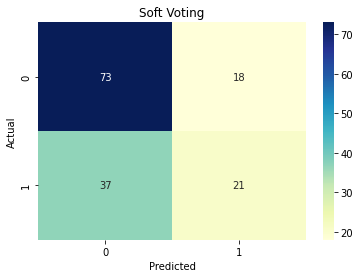

In [ ]:
test_targets = [t[0] for t in test_targets1]

cf_matrix = confusion_matrix(test_targets, final_preds)
seaborn.heatmap(cf_matrix, annot=True, cmap="YlGnBu")
plt.xlabel('Predicted', fontsize = 10) # x-axis label with fontsize 15
plt.ylabel('Actual', fontsize = 10) # y-axis label with fontsize 15
plt.title('Soft Voting', fontsize = 12) # y-axis label with fontsize 15

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(test_targets, final_preds, average='weighted')

(0.6149105927629418, 0.6308724832214765, 0.6121671446269654, None)

In [ ]:
precision_recall_fscore_support(test_targets, final_preds, average=None)

(array([0.66363636, 0.53846154]),
 array([0.8021978 , 0.36206897]),
 array([0.72636816, 0.43298969]),
 array([91, 58]))